In [1]:
import random
import pandas as pd
random.seed(671)

p = 0.05
def my_row_sampling_function(i):
    return i>0 and random.random() > p
df = pd.read_csv('user_game/user_game_time.csv', skiprows=my_row_sampling_function,index_col=0)

df.head()

,uid,gid,playtime
103,76561197970982479,21970,64
244,76561197970982479,294860,1735
359,js41637,33220,48
403,js41637,22600,0
609,js41637,220900,47


# EDA

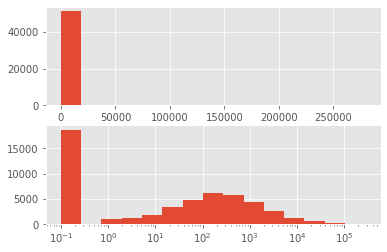

In [10]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style

def plot_dist(df, col):
    style.use('ggplot')

    x = df[col]+0.1

    plt.subplot(211)
    hist, bins, _ = plt.hist(x, bins=15)

    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    plt.subplot(212)
    plt.hist(x, bins=logbins)
    plt.xscale('log')
    plt.show()

plot_dist(df, 'playtime')

## Preprocessing

In [3]:
def NormalizeData(data): # map to [0,10]
    return (data - np.min(data)) * 10 / (np.max(data) - np.min(data))
    
def rescale(data):
    return NormalizeData(np.log10(data+0.1))

df['playtime_rescale'] = rescale(df['playtime'])
utime = df

In [4]:
x = utime['playtime_rescale']
(x.max(), x.min())

(10.0, 0.0)

In [5]:
from surprise import Reader, Dataset
from surprise import SVD, SVDpp, NMF, KNNWithMeans
from surprise.model_selection import GridSearchCV

results = []

def run(data, algo, algo_name, params, n=2): # Perform cross validation
    gs = GridSearchCV(algo, params, measures=['MAE'], n_jobs=8, cv=n) # perform grid search on parameters
    gs.fit(data) # fit data
    df = pd.DataFrame({'algo': algo_name, 'mae': gs.best_score}) # get best value with the cross validation
    results.append(df)
    return df, gs.best_params

In [6]:
reader = Reader(rating_scale=(x.min(), x.max())) # a reader of rating [1,10]
data = Dataset.load_from_df(utime[['gid', 'uid', 'playtime_rescale']], reader) # mind the order of columns

In [7]:
run(data, SVDpp, 'SVDpp', {
    'random_state': [671],
    'n_epochs': [20, 25], 
    'lr_all': [0.007, 0.01],
}, 5) # gs scd

(    algo       mae
 mae  SVD  1.802718,
 {'mae': {'random_state': 671, 'n_epochs': 25, 'lr_all': 0.01}})

# Recommend

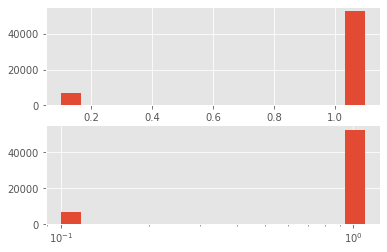

In [11]:
rec = pd.read_csv('user_game/user_game_recommend.csv',index_col=0)
plot_dist(rec, 'recommend')

In [ ]:
reader = Reader(rating_scale=(x.min(), x.max())) # a reader of rating [1,10]
data = Dataset.load_from_df(utime[['gid', 'uid', 'playtime_rescale']], reader) # mind the order of columns